In [2]:
import numpy as np
# function for european option pricing
def binomial_continuation(S_jump, K, r, sigma, T_remain, steps):
    dt = T_remain / steps
    u = np.exp(sigma * np.sqrt(dt))      
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)  

    # Binomial tree of stock values
    tree = np.zeros((steps + 1, steps + 1))
    tree[0][0] = S_jump
    for i in range(1, steps + 1):
        for j in range(i + 1):
            if j == 0:
                tree[j][i] = tree[0][i - 1] * d
            else:
                tree[j][i] = tree[j - 1][i - 1] * u

    # Payoff 
    V = np.zeros_like(tree)
    for j in range(steps + 1):
        V[j][steps] = max(tree[j][steps] - K, 0)  

    # Backward induction
    for i in reversed(range(steps)):
        for j in range(i + 1):
            V[j][i] = np.exp(-r * dt) * (q * V[j + 1][i + 1] + (1 - q) * V[j][i + 1])

    return V[0][0]  # Call's price

# Parameters
S0 = 100              # Stock value at t=0
K = 95                # Strike
r = 0.05              # risk-free
sigma = 0.2           # Volatility
T = 90 / 252          # Time to maturity
N = 90                # Step
dt = T / N            # Time Step
D = 2                 # Discrete Dividend
X = 0                 # exogenous random shock
div_step = 30         # Day on wich the dividend occurs

#Binomial Steps
u = np.exp(sigma * np.sqrt(dt))    # up factor
d = 1 / u                          # down factor
q = (np.exp(r * dt) - d) / (u - d)  # risk neutral probability of up
S=np.zeros((N+1,N+1))
S[0][0]=S0
# Binomial tree of stock values
for i in range(1,N+1):
    for j in range(i+1):
        if j==0:
            S[j][i]=S[0][i-1]*d
        else:
            S[j][i]=S[j-1][i-1]*u
        if i==div_step:
            S[j][i]=max(S[j][i]-D,0)*(1+X)
#S* estimate  
T1 = div_step - 1
T2 = div_step
S_star = None
payoff_list = []
continuation_list = []
spread = []

for j in range(T1 + 1):
    s = S[j][T1]
    immediate = max(s - K, 0)

    # post-jump 
    s_jump = max(s - D, 0) * (1 + X)

    # after T2
    T_remain = (N - T2) * dt
    steps_remain = N - T2

    if steps_remain > 0:
        cont_val = binomial_continuation(s_jump, K, r, sigma, T_remain, steps_remain)
    else:
        cont_val = max(s_jump - K, 0)

    payoff_list.append(immediate)
    continuation_list.append(cont_val)
    spread.append(immediate - cont_val)

for j in range(1, len(spread)):
    if spread[j-1] < 0 and spread[j] > 0:
        s_low = S[j-1][T1]
        s_high = S[j][T1]
        S_star = (s_low + s_high) / 2
        break

print(f"estimate of S* (via binomial continuation): {S_star:.4f}")

#BACKWARD INDUCTION
V = np.zeros_like(S)
for j in range(T1 + 1):
    s = S[j][T1]
    if s > S_star:
        V[j][T1] = max(s - K, 0)
    else:
        s_jump = max(s - D, 0) * (1 + X)
        T_remain = (N - T2) * dt
        steps_remain = N - T2
        if steps_remain > 0:
            V[j][T1] = binomial_continuation(s_jump, K, r, sigma, T_remain, steps_remain)
        else:
            V[j][T1] = max(s_jump - K, 0)

for i in reversed(range(T1)):
    for j in range(i+1):
        continuation= np.exp(-r*dt)*(V[j][i+1]*q+V[j+1][i+1]*(1-q))
        exercise=max(S[j][i]-K,0)
        V[j][i]=max(exercise, continuation)
            
        
 
print(f"American Call price: {V[0][0]:.4f}")
        
        
            


estimate of S* (via binomial continuation): 105.1770
American Call price: 6.9203


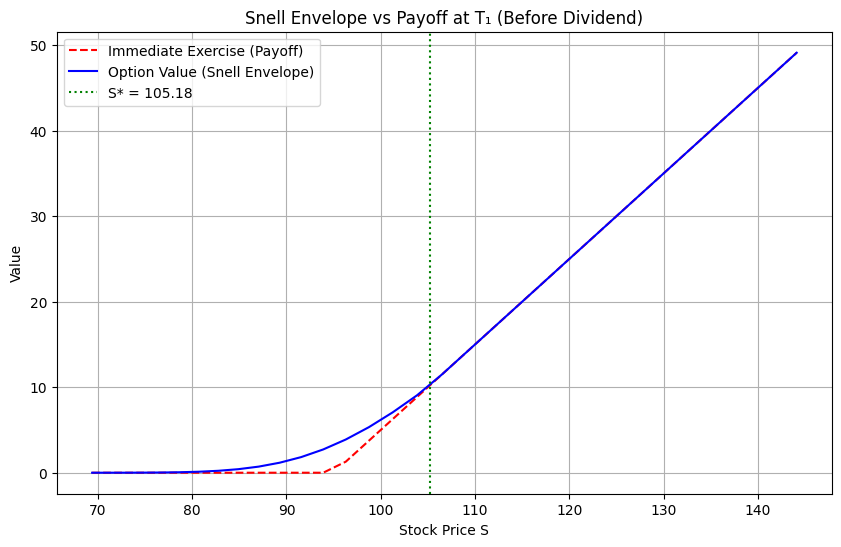

In [3]:
import matplotlib.pyplot as plt

T1 = div_step - 1 
x_vals = []
payoff_vals = []
option_vals = []

for j in range(T1 + 1):
    s = S[j][T1]
    v = V[j][T1]
    payoff = max(s - K, 0)

    x_vals.append(s)
    payoff_vals.append(payoff)
    option_vals.append(v)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, payoff_vals, 'r--', label='Immediate Exercise (Payoff)')
plt.plot(x_vals, option_vals, 'b-', label='Option Value (Snell Envelope)')
plt.axvline(S_star, color='green', linestyle=':', label=f"S* = {S_star:.2f}")
plt.title("Snell Envelope vs Payoff at T₁ (Before Dividend)")
plt.xlabel("Stock Price S")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
